In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
from torchvision import transforms,datasets
import torch.nn.functional as F
import os


data_path = "data"
print(os.listdir(data_path))
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

labels = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
cuda:0


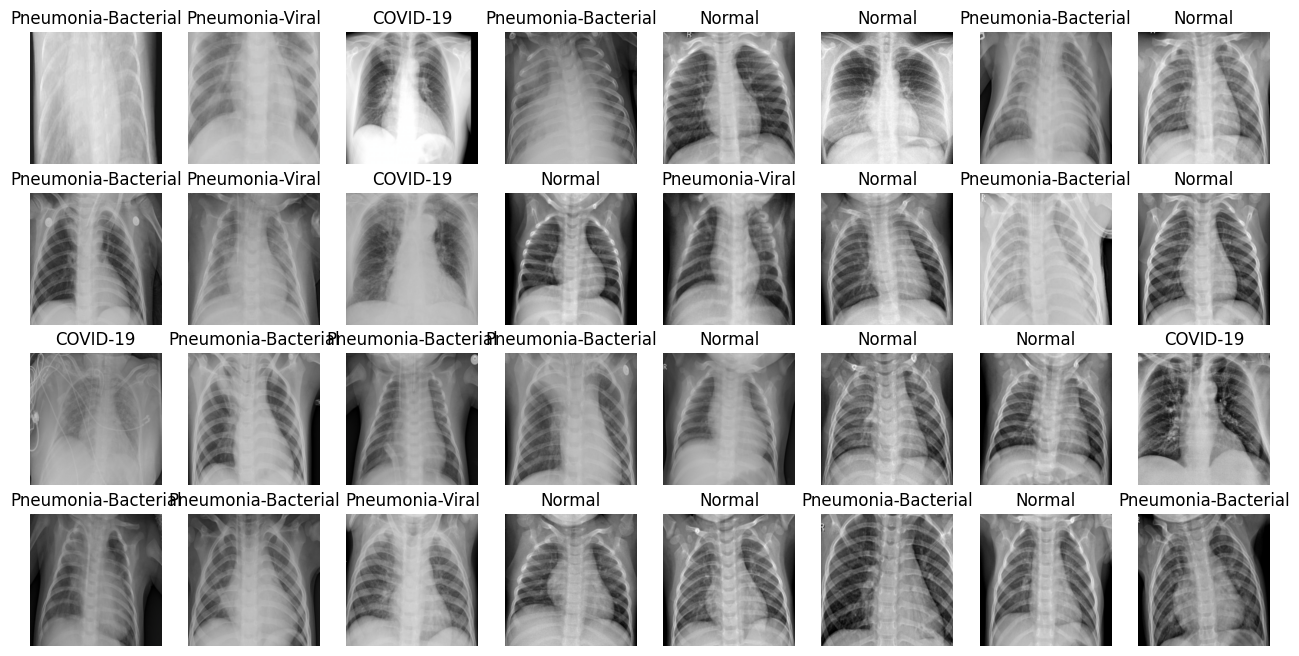

In [2]:
transformed_data = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])



dataset = datasets.ImageFolder(data_path,transform=transformed_data)


train_split =  int(len(dataset) * 0.8)
test_split = len(dataset) - train_split

train_data,test_data = torch.utils.data.random_split(dataset, lengths=[train_split,test_split])


BATCH_SIZE = 32
epochs = 5
learning_rate = 0.001


train_dataloader = torch.utils.data.DataLoader(train_data,BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,BATCH_SIZE,shuffle=False)




def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image * std + mean
    return np.clip(image,0,1)


images,labels = next(iter(train_dataloader))



fig,axs = plt.subplots(4,8,figsize=(16,8))


for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()

In [3]:

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.con1 = nn.Conv2d(3, 32, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.con2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.con3 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.con4 = nn.Conv2d(128, 224, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(224)
        self.pool4 = nn.MaxPool2d(2,2)
        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(14*14*224,512)
        self.fc2 = nn.Linear(512, 4)
        
    def forward(self,x):
        x = self.pool1(F.relu(self.bn1(self.con1(x))))
        x = self.pool2(F.relu(self.bn2(self.con2(x))))
        x = self.pool3(F.relu(self.bn3(self.con3(x))))
        x = self.pool4(F.relu(self.bn4(self.con4(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



model = Net()
model.to(device)        

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

In [4]:
for epoch in range(epochs):
    running_loss = 0.0
    for i,(images,labels) in enumerate(train_dataloader):
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")


Epoch [1/5], Loss: 1.5934
Epoch [2/5], Loss: 0.4691
Epoch [3/5], Loss: 0.4198
Epoch [4/5], Loss: 0.3877
Epoch [5/5], Loss: 0.3653


In [ ]:
model.eval()
with torch.no_grad():
    y_test = []
    y_pred = []
    correct = 0
    total = 0
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())
        loss = criterion(outputs,labels)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
print(f'Accuracy: {correct * 100 / total}')




print(classification_report(y_test,y_pred))



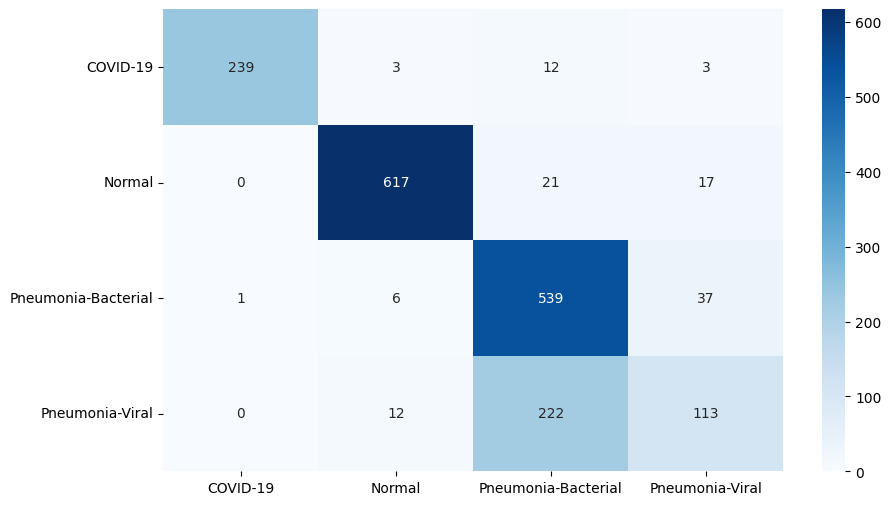

In [6]:
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",xticklabels=['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'],yticklabels=['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'])



plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, y_pred)
plt.show()

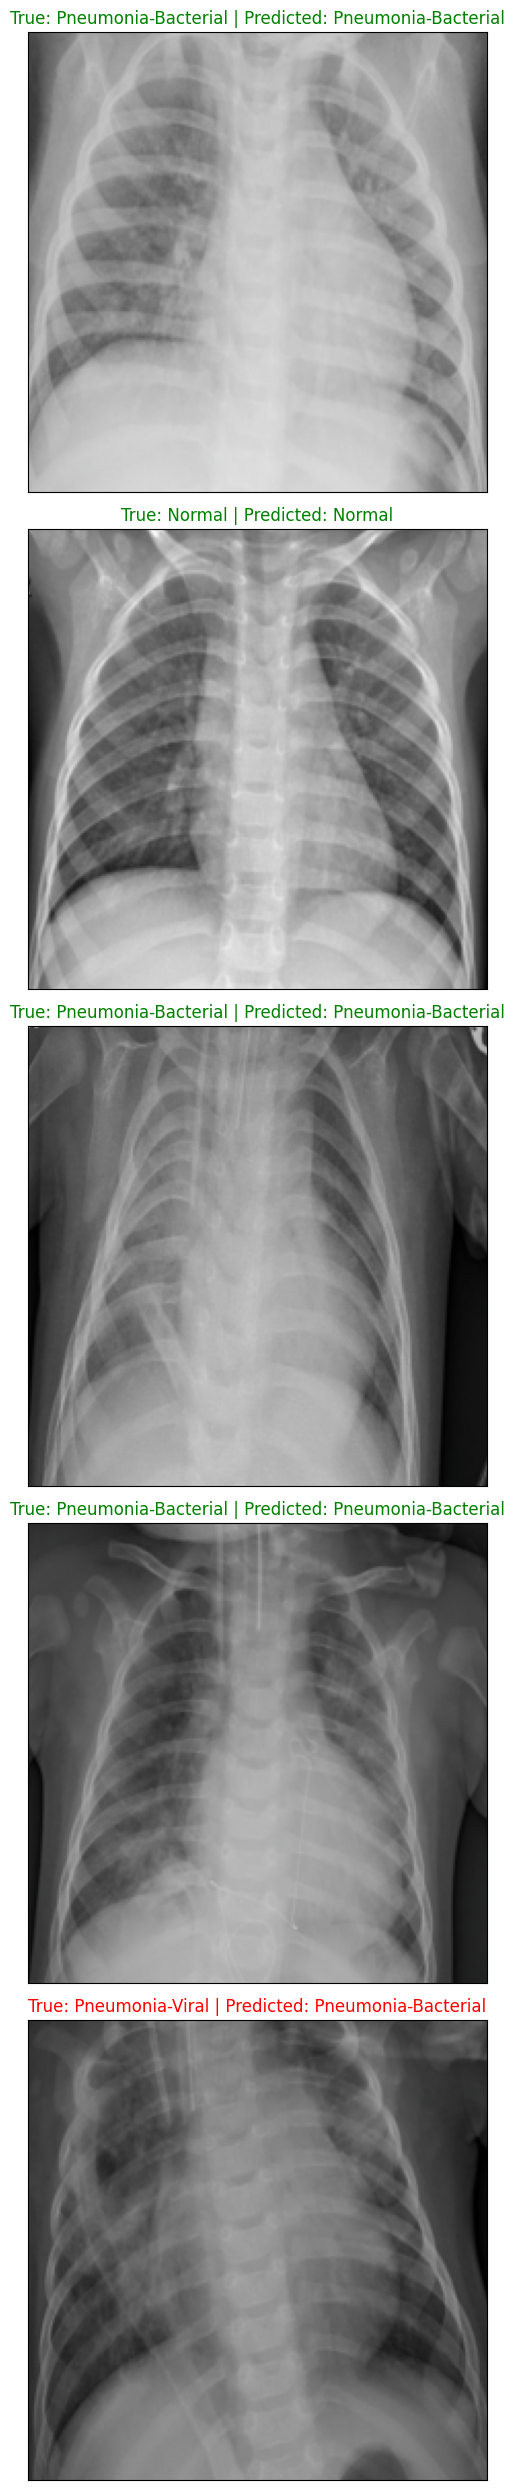

In [7]:

rand_indices = np.random.choice(len(y_pred), size=min(5,len(y_pred)),replace=False)
plt.figure(figsize=(10, 5 * len(rand_indices)))
for i, index in enumerate(rand_indices):
    image = img_inv(test_data[index][0])
    plt.subplot(len(rand_indices),1, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    predicted_class = dataset.classes[y_pred[index]]
    true_class = dataset.classes[y_test[index]]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()
